In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ, GaussianBases #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=1,suppress=True)

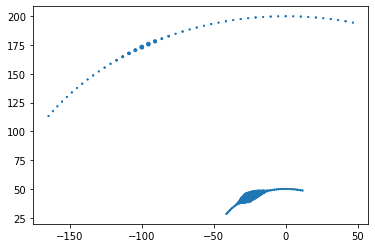

In [2]:
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y #scaling
boundary = proposeboundary(X)
boundary[0][2]=-30 #puts the source on the grid!
boundary[0][0]=-120 #add two minutes to start

dist = np.round(X[:,2]**2+X[:,3]**2).astype(int)
keep = dist==10000 #2500, 10000, 40000
Xtest = X[keep,:]
Ytest = Y[keep]
X = X[~keep,:]
Y = Y[~keep]
plt.scatter(X[:,2],X[:,3],Y/10+1)

In [3]:
np.array(boundary[1])-np.array(boundary[0])

array([780., 254., 248.])

In [4]:
#set up our model...
N_feat = 3000 #25^3 #2197 #10000 #Number of features used to infer the source
Nparticles = 10
k = EQ(np.array([200,9,9]), 200)
#k = GaussianBases(np.array([120,9,9]), 200)
res = [100,60,70]
noiseSD = 0.01
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(rh.experiments[0].windX,rh.experiments[0].windY)
k_0 = 1
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) 
mInfer.computeModelRegressors(Nparticles=Nparticles) # Compute regressor matrix
print("Computed Regressors")
meanZ, covZ = mInfer.computeZDistribution(Y)

Nsamps = 20
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
scaleby = [8,1,1]    
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]].transpose([1,2,3,0])
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=Nparticles,Zs=Zs,interpolateSource=True,coords=coords)

gridsource = mInfer.getGridCoord(np.array([0,0,0])) #location of ground truth source
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
mInferCoords = mInfer.coords

testsensors = FixedSensorModel(Xtest,3)
particles = mInfer.genParticlesFromObservations(50,testsensors)#[:,:,:]#.transpose([3,0,1,2,4])
meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=Zs,interpolateSource=True)

Initialising particles...
Computed Regressors
Computing SS...
Inverting SS...
Computing meanZ
Done


<ipython-input-4-7d1d2a059159>:20: RuntimeWarning: covariance is not positive-semidefinite.
  Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)


cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
Initialising particles...
(13, 60, 70, 3)
(10, 13, 60, 70, 3)
Particle shape:
(10, 13, 60, 70, 3)
Diffusing particles...
Initialising particles...
Particle shape:
(50, 117, 3)
Diff

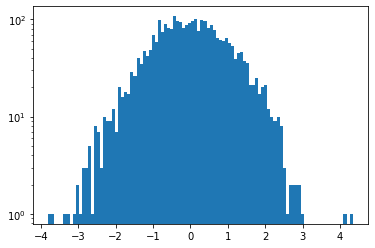

In [5]:
plt.hist(Zs[0],100,log=True);

In [6]:
mInfer.kernel.getPhiValues(particles).shape

(3000, 117, 50)

In [7]:
#particles = mInfer.genParticlesFromObservations(50,testsensors)#[:,:,:]#.transpose([3,0,1,2,4])
#np.mean(np.abs(mInfer.kernel.getPhiValues(particles)))

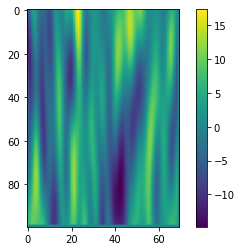

In [8]:
plt.imshow(sourcemean[:,30,:])
plt.colorbar()
#plt.clim([-100,100])

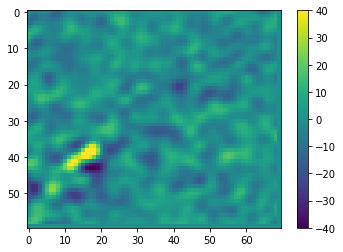

In [9]:
plt.imshow(sourcemean[20,:,:])
plt.colorbar()
plt.clim([-40,40])

In [10]:
import pickle
#pickle.dump([gridsource,gridX,mInferCoords,testsensors,particles,meanobs,varobs,obs,mInfer],open('cache6.pkl','wb'))
#gridsource,gridX,mInferCoords,testsensors,particles,meanobs,varobs,obs,mInfer = pickle.load(open('cache6.pkl','rb'))


23


/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


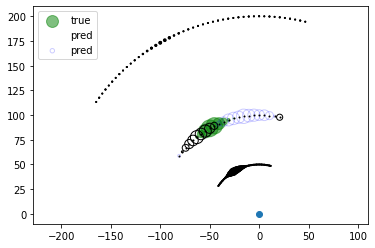

In [11]:
keep = Xtest[:,1]==600
print(sum(keep))
plt.scatter(Xtest[keep,2],Xtest[keep,3],Ytest[keep],c='green',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],meanobs[keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],-meanobs[keep],alpha=0.2,c='none',edgecolors='b',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],1,c='k')
plt.scatter(X[:,2],X[:,3],1+Y/20,c='k')
plt.plot([0],[0],'o')
plt.axis('equal')
plt.legend()

In [12]:
import dill
dill.dump_session('roundhill_save2.pkl')
dill.load_session('roundhill_save2.pkl')

In [13]:
mInfer.boundary

[array([-120., -186.,  -30.]), array([660.,  68., 218.])]

In [14]:
mInfer.getGridCoord([0,0,0])

array([15, 43,  8])

In [15]:
from advectionGP.kernels import meshgridndim
#Xnonneg = meshgridndim(mInfer.boundary,12,True)
Xnonneg = meshgridndim([np.array([-100., -100.,  -30.]), np.array([100.,  100, 100])],15,True)

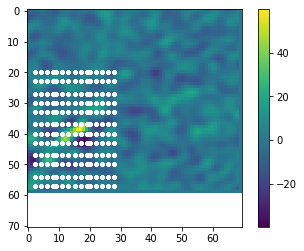

In [33]:
plt.imshow(np.mean(sourcesNoNeg[:,11,:,:],0))
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw')
plt.plot(gridCoordsXnonneg[:,0],gridCoordsXnonneg[:,1],'.w')
#plt.clim([0,40])

In [16]:
Xnonneg.shape

(3375, 3)

In [17]:
from advectionGP.constraints import NonNegConstraint
#nnc = NonNegConstraint(mInfer,Y,Xnonneg,thinning=20,jitter=1e-3,verbose=True,burnin=100,usecaching=False)#,startpointnormalised=True)
#samps = nnc.sample(20,use_sparse_startpoint=False) #spare start point makes it overly smooth etc
samps = Zs

#print("Checking convergence. Gelman Rubin statistic: (should be less than about 1.2)")
#print(nnc.check_convergence(Nchains=5))

In [18]:
samps

array([[ 0.7,  1.6,  0.5, ..., -1.1,  0.4, -0.1],
       [ 0.3,  1.1, -0.6, ...,  1.4,  0.5, -2.1],
       [-0.1, -0.2,  0.9, ..., -0.9,  0.2,  0.5],
       ...,
       [ 0.6, -0.6,  1.5, ..., -0.5, -0.4,  0.5],
       [ 0.2,  0.6, -0.9, ..., -1.1, -1.8, -1.8],
       [-0.4, -0.4, -0.4, ..., -0.5, -0.2, -0.2]])

In [19]:
planes = np.array([phi for phi in mInfer.kernel.getPhi(Xnonneg.T)])


In [20]:
np.all(planes.T @ samps.T>0)

False

In [21]:
#particles = mInfer.genParticlesFromObservations(100,testsensors)[None,None,:,:,:]
#meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=np.mean(samps,0)[None,:],interpolateSource=True)

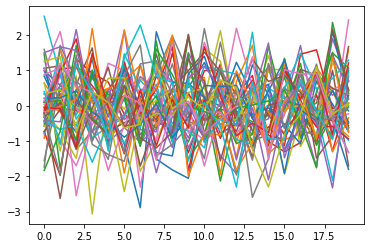

In [22]:
plt.plot(samps[:,::60]-np.mean(samps[:,::60],0));

In [23]:
#for samp in samps:
#    particles = mInfer.genParticlesFromObservations(100,testsensors)[None,None,:,:,:]
#    meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=samp[None,:],interpolateSource=True)
#    break

In [24]:
sourcesNoNeg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in samps])
#sourcesNoNeg = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in np.mean(samps,0)[None,:]])
sourcemean = np.mean(sourcesNoNeg,0)
sourcevar = np.var(sourcesNoNeg,0)    

In [26]:
#pickle.dump([nnc, samps, Xnonneg, keep, meanobs,varobs,obs, particles, testsensors,mInfer, gridX, gridsource, concmean,concvar,concentrations,sources,sourcemean,sourcevar,coords,Zs, meanZ, covZ, k_0, windmodel, sensors, noiseSD,res, k, Nparticles, N_feat, sourcesNoNeg],open('save1.pkl','wb'))

In [27]:
source_grid_pos = mInfer.getGridCoord([0,0,0])
source_grid_pos

array([15, 43,  8])

In [31]:
gridCoordsXnonneg = mInfer.getGridCoord(Xnonneg)

array([[ 2, 20,  0],
       [ 2, 20,  2],
       [ 2, 20,  5],
       ...,
       [28, 67, 31],
       [28, 67, 34],
       [28, 67, 36]])

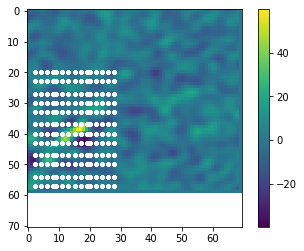

In [32]:
plt.imshow(np.mean(sourcesNoNeg[:,11,:,:],0))
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw')
plt.plot(gridCoordsXnonneg[:,0],gridCoordsXnonneg[:,1],'.w')
#plt.clim([0,40])

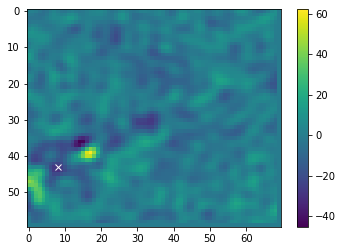

In [44]:
plt.imshow(np.mean(sources[:,11,:,:],0))
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw')
#plt.clim([0,40])

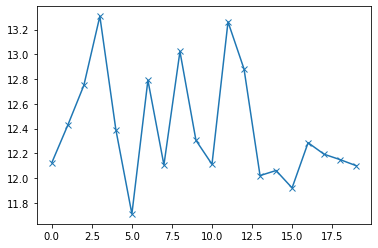

In [38]:
plt.plot(np.mean(np.abs(sourcesNoNeg),axis=(1,2,3)),'x-')

In [39]:
[np.unique(t) for t in mInfer.getGridCoord(Xnonneg).T]

[array([ 2,  4,  6,  8,  9, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28]),
 array([20, 23, 27, 30, 33, 37, 40, 43, 47, 50, 54, 57, 60, 64, 67]),
 array([ 0,  2,  5,  7, 10, 13, 15, 18, 20, 23, 26, 28, 31, 34, 36])]

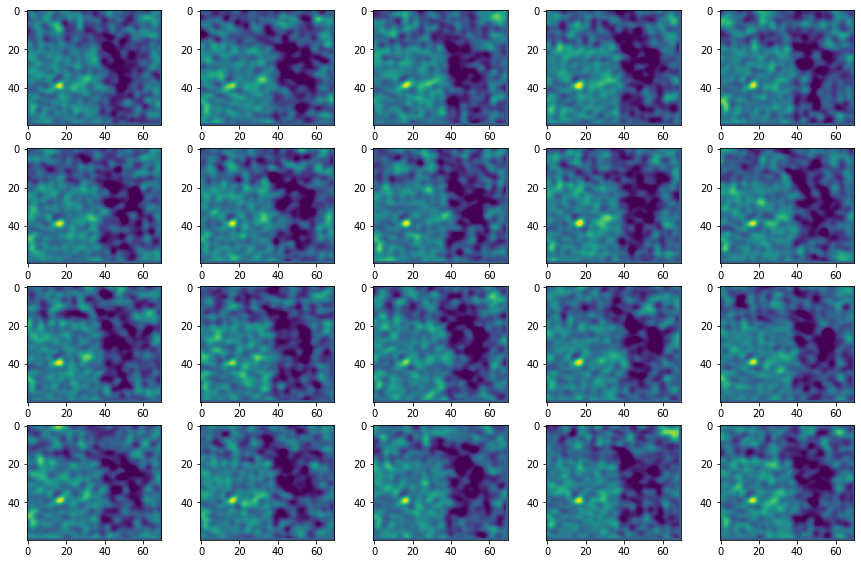

In [45]:
plt.figure(figsize=[15,25])
for i,s in enumerate(sourcesNoNeg):
    plt.subplot(10,5,i+1)
    plt.imshow(s[15,:,:])#-np.mean(sourcesNoNeg[:,10,:,:],0))#sources[1,10,:,:])
    #plt.colorbar()
    plt.clim([-35,80])
    #if i==4: plt.colorbar()

In [46]:
[np.unique(t) for t in mInfer.getGridCoord(Xnonneg).T]

[array([ 2,  4,  6,  8,  9, 11, 13, 15, 17, 19, 20, 22, 24, 26, 28]),
 array([20, 23, 27, 30, 33, 37, 40, 43, 47, 50, 54, 57, 60, 64, 67]),
 array([ 0,  2,  5,  7, 10, 13, 15, 18, 20, 23, 26, 28, 31, 34, 36])]

(-40.0, 60.0)

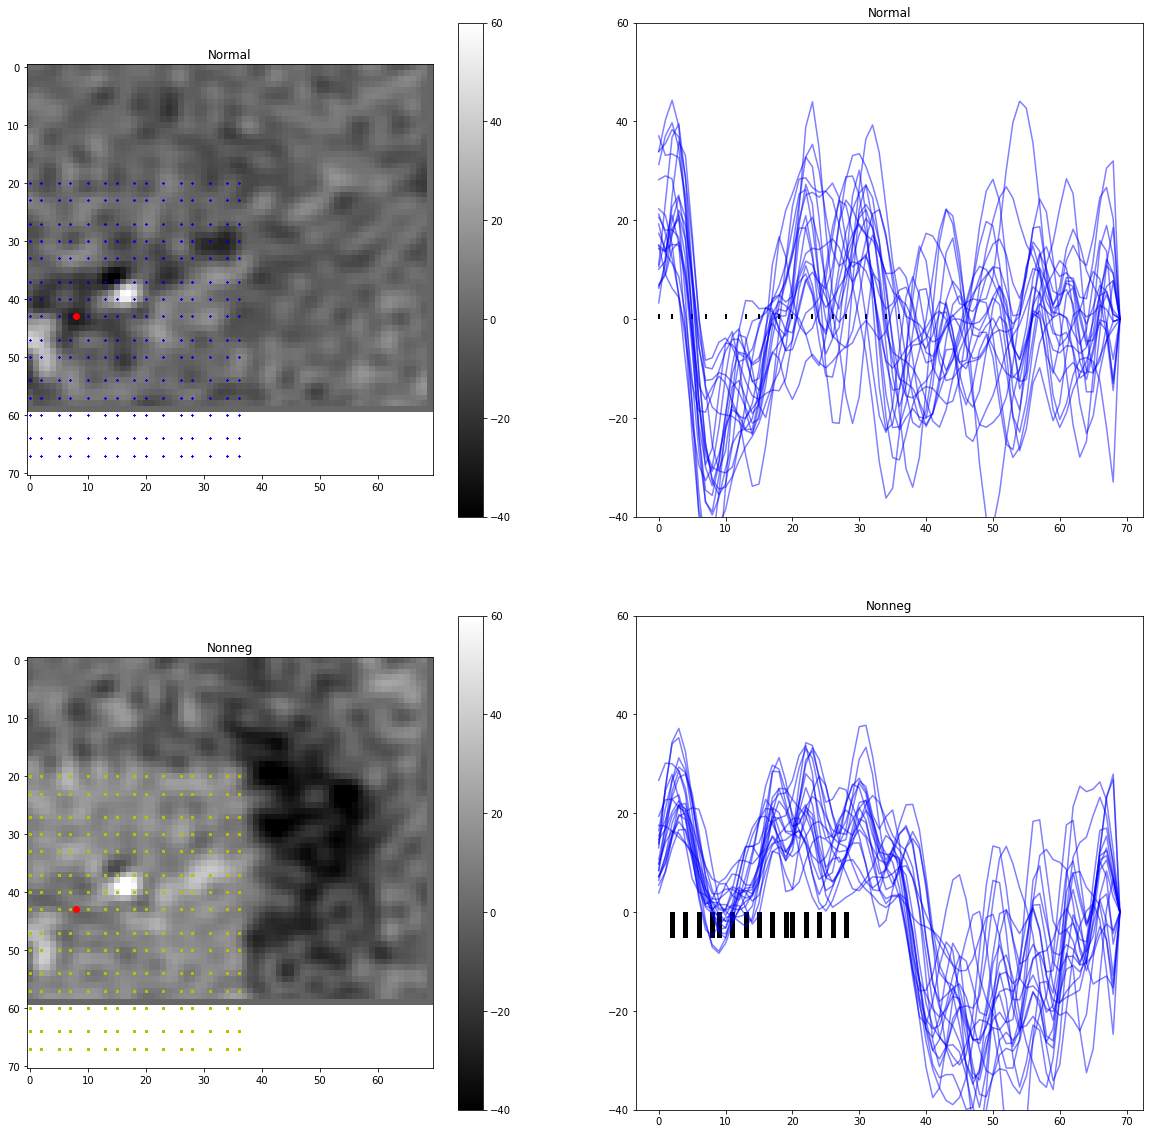

In [47]:
slicepoint = [12,44]
plt.figure(figsize=[20,20])
plt.subplot(2,2,1)
plt.title('Normal')
plt.imshow(np.mean(sources[:,slicepoint[0],:,:],0),cmap='gray')
plt.clim([-40,60])
plt.colorbar()
plt.plot(mInfer.getGridCoord(Xnonneg)[:,2],mInfer.getGridCoord(Xnonneg)[:,1],'.b',alpha=1,markersize=1)
realsourcegridpos = mInfer.getGridCoord(np.array([[0,0,0]]))
plt.plot(realsourcegridpos[0][2],realsourcegridpos[0][1],'or')
plt.subplot(2,2,2)
plt.title('Normal')
plt.plot(sources[:,slicepoint[0],slicepoint[1],:].T,'b-',alpha=0.5)
plt.vlines(mInfer.getGridCoord(Xnonneg)[:,2],0,1)
plt.ylim([-40,60])
plt.subplot(2,2,3)
plt.title('Nonneg')
plt.imshow(np.mean(sourcesNoNeg[:,slicepoint[0],:,:],0),cmap='gray')
plt.clim([-40,60])
plt.colorbar()
plt.plot(mInfer.getGridCoord(Xnonneg)[:,2],mInfer.getGridCoord(Xnonneg)[:,1],'.y',alpha=1,markersize=3)
realsourcegridpos = mInfer.getGridCoord(np.array([[0,0,0]]))
plt.plot(realsourcegridpos[0][2],realsourcegridpos[0][1],'or')
plt.subplot(2,2,4)
plt.title('Nonneg')
plt.plot(sourcesNoNeg[:,slicepoint[0],slicepoint[1],:].T,'b-',alpha=0.5)
plt.vlines(mInfer.getGridCoord(Xnonneg)[:,0],-5,0,lw=5)
plt.ylim([-40,60])


In [52]:
testsensors = FixedSensorModel(Xtest,3)
particles = mInfer.genParticlesFromObservations(10,testsensors)#[:,:,:]#.transpose([3,0,1,2,4])
meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=samps,interpolateSource=True)

Initialising particles...
Particle shape:
(10, 117, 3)
Diffusing particles...


In [53]:
trainsensors = FixedSensorModel(X,3)
particles = mInfer.genParticlesFromObservations(10,trainsensors)#[:,:,:]#.transpose([3,0,1,2,4])
meanobstrain,varobstrain,obstrain = mInfer.computeConcentration(particles=particles,Zs=samps,interpolateSource=True)

Initialising particles...
Particle shape:
(10, 234, 3)
Diffusing particles...


In [54]:
meanobs.shape

(117,)

23


/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


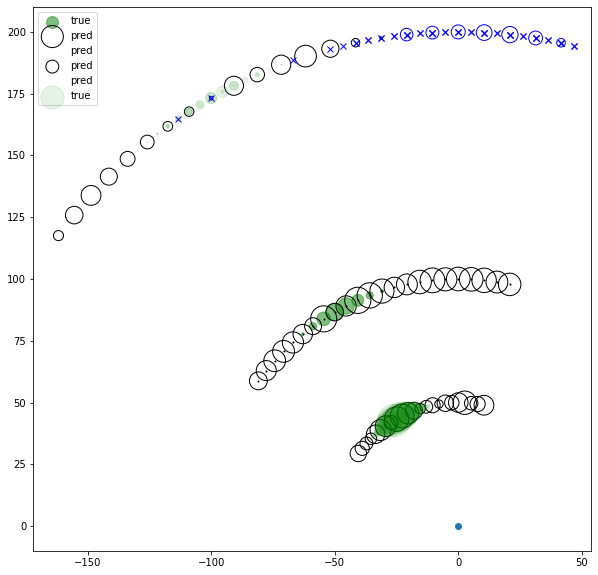

In [55]:

keep = Xtest[:,1]==600
print(sum(keep))
plt.figure(figsize=[10,10])
thrs = -1
plt.scatter(Xtest[keep,2],Xtest[keep,3],Ytest[keep],c='green',alpha=0.5,label='true')
plt.scatter(Xtest[keep,2],Xtest[keep,3],meanobs[keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(Xtest[keep,2],Xtest[keep,3],-meanobs[keep],alpha=1,c='none',edgecolors='b',label='pred')
plt.plot(Xtest[meanobs<thrs,2],Xtest[meanobs<thrs,3],'bx')
plt.scatter(Xtest[keep,2],Xtest[keep,3],1,c='k')

keep = X[:,1]==600
plt.scatter(X[keep,2],X[keep,3],meanobstrain[keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(X[keep,2],X[keep,3],-meanobstrain[keep],alpha=1,c='none',edgecolors='b',label='pred')
#plt.scatter(X[:,2],X[:,3],1+Y/20,c='k')
plt.scatter(X[:,2],X[:,3],Y,c='green',alpha=0.1,label='true')
plt.plot(X[meanobstrain<thrs,2],X[meanobstrain<thrs,3],'bx')
plt.plot([0],[0],'o')
plt.axis('equal')
plt.legend()

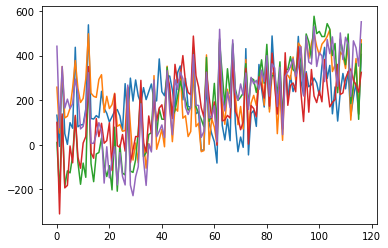

In [45]:
plt.plot(obs.T);